In [2]:
 import pandas as pd

In [1]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from gensim.models import Word2Vec, KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
pd = pd.read_csv('/content/Articles.csv')
pd

,Date published,Category,Section,Headline,Description,Keywords,Article text
0,2021-07-15 02:46:59,news,world,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","(CNN)Right now, there's a shortage of truck d..."
1,2021-05-12 07:52:09,news,world,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",(CNN)Working in a factory or warehouse can me...
2,2021-06-16 02:51:30,news,asia,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...","(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,2022-03-15 09:57:36,business,investing,Russia is no longer an option for investors. T...,"For many years, the world's most popular emerg...","investing, Russia is no longer an option for i...","New York (CNN Business)For many years, the wor..."
4,2022-03-15 11:27:02,business,business,Russian energy investment ban part of new EU s...,The European Union formally approved on Tuesda...,"business, Russian energy investment ban part o...",The European Union formally approved on Tuesda...
...,...,...,...,...,...,...,...
4071,2021-12-01 10:01:29,sport,tennis,Australian Open: Australia's vaccine mandate i...,The Australian Open's Covid-19 vaccine mandate...,"tennis, Australian Open: Australia's vaccine m...",(Reuters)The Australian Open's Covid-19 vacci...
4072,2021-12-01 17:56:15,sport,golf,Four golfers test positive ahead of South Afri...,Four golfers scheduled to play in the South Af...,"golf, Four golfers test positive ahead of Sout...",(CNN)Four golfers scheduled to play in the So...
4073,2021-12-01 11:32:15,sport,tennis,Peng Shuai: 'Unanimous conclusion' that tennis...,Long-time International Olympic Committee (IOC...,"tennis, Peng Shuai: 'Unanimous conclusion' tha...",(CNN)Long-time International Olympic Committe...
4074,2021-12-01 17:27:34,news,europe,"This company is ""zapping"" cow dung with lightn...",A Norwegian technology company has found a way...,"europe, This company is ""zapping"" cow dung wit...",A Norwegian technology company has found a way...


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
# helper display function used in notebook: caas_jupyter_tools.display_dataframe_to_user

# Load
df = pd.read_csv("/content/Articles.csv", low_memory=False)

# Basic inspection
df.info()
df.head()

# Missing values summary
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

# Duplicate check
df.duplicated().sum()

# Detect column types
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
object_cols = df.select_dtypes(include=['object']).columns.tolist()

# Drop columns with >80% missing (none in this dataset)
threshold = 0.8 * len(df)
high_missing_cols = missing[missing > threshold].index.tolist()
df_clean = df.drop(columns=high_missing_cols)

# Parse date-like columns
for col in df_clean.columns:
    if df_clean[col].dtype == object:
        sample = df_clean[col].dropna().astype(str).head(20).tolist()
        if any(re.match(r"^\d{4}-\d{2}-\d{2}", s) for s in sample):
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce', infer_datetime_format=True)

# Fill missing values
# numeric -> median (not applicable here)
# short object -> mode; long text -> empty string
for col in object_cols:
    if col in df_clean.columns:
        avg_len = df_clean[col].dropna().astype(str).map(len).mean() if df_clean[col].notnull().any() else 0
        if avg_len > 50:
            df_clean[col] = df_clean[col].fillna("")
        else:
            mode = df_clean[col].mode(dropna=True)
            fill = mode.iloc[0] if len(mode) > 0 else ""
            df_clean[col] = df_clean[col].fillna(fill)

# Remove exact duplicates
df_clean = df_clean.drop_duplicates().reset_index(drop=True)

# Stats & plots (matplotlib only)
# - numeric describe (if numeric cols)
# - histograms for up to 4 numeric columns
# - bar plots for top values in first 3 object columns
# - correlation matrix heatmap if >=2 numeric columns
# - token-count top words for the first detected long text column

# Save cleaned CSV
df_clean.to_csv("/content/Articles.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4076 entries, 0 to 4075
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date published  4076 non-null   object
 1   Category        4076 non-null   object
 2   Section         4076 non-null   object
 3   Headline        4076 non-null   object
 4   Description     4076 non-null   object
 5   Keywords        4076 non-null   object
 6   Article text    4076 non-null   object
dtypes: object(7)
memory usage: 223.0+ KB


/tmp/ipython-input-1876653177.py:36: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce', infer_datetime_format=True)


In [7]:
import pandas as pd

# Load your dataset
df = pd.read_csv("/content/Articles.csv")   # or Articles.csv if you want the raw file

# Check total null values in each column
print(df.isnull().sum())

# Check percentage of null values in each column
print((df.isnull().sum() / len(df)) * 100)


Date published    0
Category          0
Section           0
Headline          0
Description       0
Keywords          0
Article text      0
dtype: int64
Date published    0.0
Category          0.0
Section           0.0
Headline          0.0
Description       0.0
Keywords          0.0
Article text      0.0
dtype: float64


In [6]:
# All at once
print(df.shape)
print(df.columns)
print(df.info())
print(df.describe(include='all'))
print(df.nunique())
print(df.isnull().sum())

(4076, 7)
Index(['Date published', 'Category', 'Section', 'Headline', 'Description',
       'Keywords', 'Article text'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4076 entries, 0 to 4075
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date published  4076 non-null   object
 1   Category        4076 non-null   object
 2   Section         4076 non-null   object
 3   Headline        4076 non-null   object
 4   Description     4076 non-null   object
 5   Keywords        4076 non-null   object
 6   Article text    4076 non-null   object
dtypes: object(7)
memory usage: 223.0+ KB
None
             Date published Category Section  \
count                  4076     4076    4076   
unique                 4076        6      37   
top     2021-07-15 02:46:59    sport   sport   
freq                      1     2176    1088   

                                                 Headline  \
count 

Shape: (4076, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4076 entries, 0 to 4075
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date published  4076 non-null   object
 1   Category        4076 non-null   object
 2   Section         4076 non-null   object
 3   Headline        4076 non-null   object
 4   Description     4076 non-null   object
 5   Keywords        4076 non-null   object
 6   Article text    4076 non-null   object
dtypes: object(7)
memory usage: 223.0+ KB
None
Date published    0
Category          0
Section           0
Headline          0
Description       0
Keywords          0
Article text      0
dtype: int64
Duplicates: 0


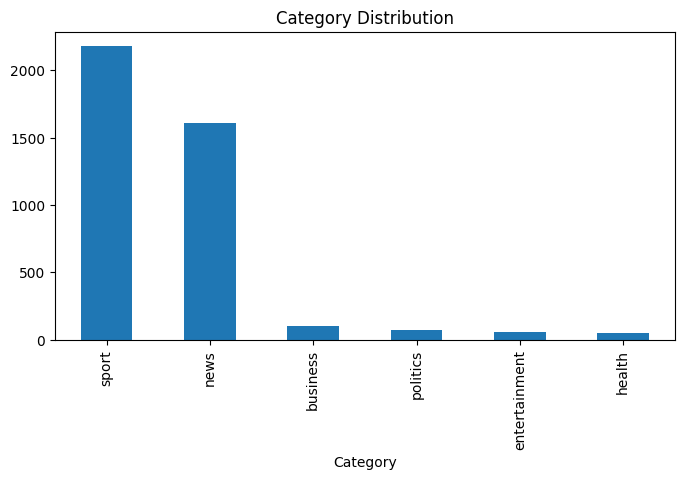

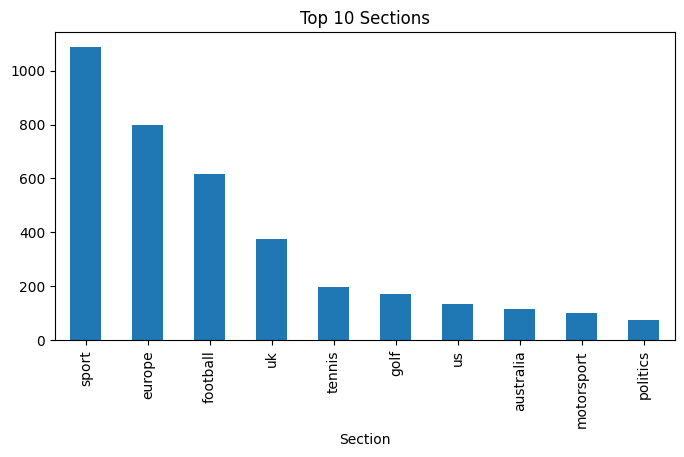

Section        africa  americas  asia  australia  business  business-food  \
Category                                                                    
business            0         0     0          0        23              1   
entertainment       0         0     0          0         0              0   
health              0         0     0          0         0              0   
news               49         3     9        114         0              0   
politics            0         0     0          0         0              0   

Section        business-money  cars  celebrities  china  ...  perspectives  \
Category                                                 ...                 
business                    2     1            0      0  ...            25   
entertainment               0     0            1      0  ...             0   
health                      0     0            0      0  ...             0   
news                        0     0            0      5  ...          

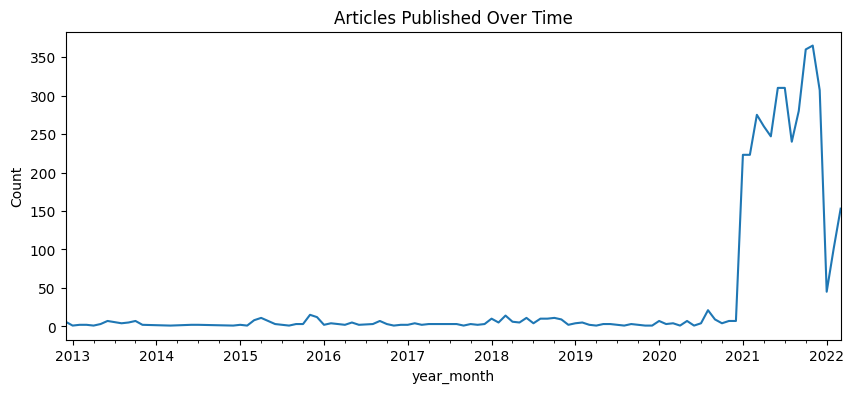

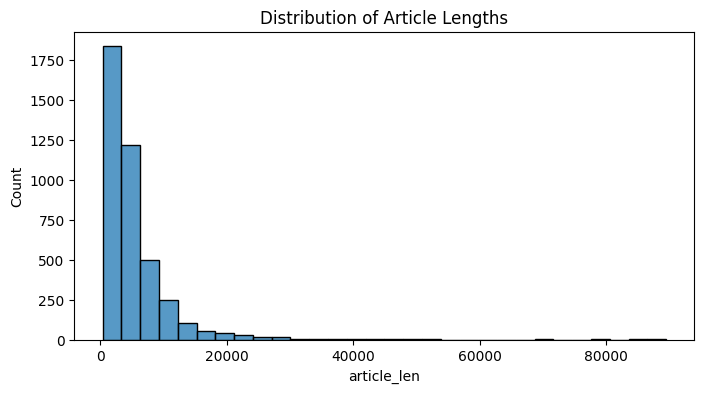

Top 20 headline words: [('cnn', 4017), ('the', 1094), ('and', 626), ('for', 564), ('after', 396), ('with', 300), ('says', 279), ('covid', 273), ('from', 192), ('league', 173), ('first', 169), ('new', 168), ('over', 163), ('world', 161), ('are', 154), ('olympics', 151), ('his', 144), ('how', 137), ('tokyo', 134), ('open', 133)]


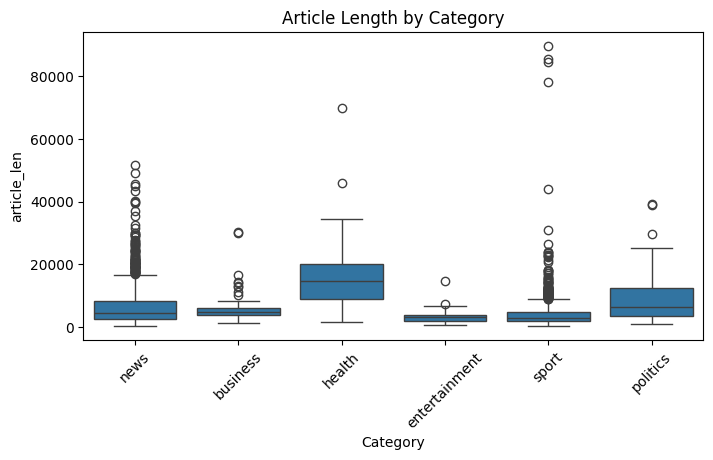

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import re

# Load dataset
df = pd.read_csv("/content/Articles.csv")

# ----------------------------
# 1. Overview
# ----------------------------
print("Shape:", df.shape)
print(df.info())
print(df.isnull().sum())
print("Duplicates:", df.duplicated().sum())

# ----------------------------
# 2. Category & Section Analysis
# ----------------------------
plt.figure(figsize=(8,4))
df['Category'].value_counts().plot(kind='bar')
plt.title("Category Distribution")
plt.show()

plt.figure(figsize=(8,4))
df['Section'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Sections")
plt.show()

# Cross-tab Category vs Section
cross_tab = pd.crosstab(df['Category'], df['Section'])
print(cross_tab.head())

# ----------------------------
# 3. Time Analysis
# ----------------------------
df['Date published'] = pd.to_datetime(df['Date published'])
df['year_month'] = df['Date published'].dt.to_period('M')

plt.figure(figsize=(10,4))
df.groupby('year_month').size().plot()
plt.title("Articles Published Over Time")
plt.ylabel("Count")
plt.show()

# ----------------------------
# 4. Text Analysis
# ----------------------------
# Length of text fields
df['headline_len'] = df['Headline'].astype(str).apply(len)
df['desc_len'] = df['Description'].astype(str).apply(len)
df['article_len'] = df['Article text'].astype(str).apply(len)

# Plot distribution of article lengths
plt.figure(figsize=(8,4))
sns.histplot(df['article_len'], bins=30)
plt.title("Distribution of Article Lengths")
plt.show()

# Top words in Headline
all_words = " ".join(df['Headline']).lower()
words = re.findall(r"\b[a-zA-Z]{3,}\b", all_words)
common_words = Counter(words).most_common(20)
print("Top 20 headline words:", common_words)

# ----------------------------
# 5. Relationship Example
# ----------------------------
plt.figure(figsize=(8,4))
sns.boxplot(x="Category", y="article_len", data=df)
plt.xticks(rotation=45)
plt.title("Article Length by Category")
plt.show()


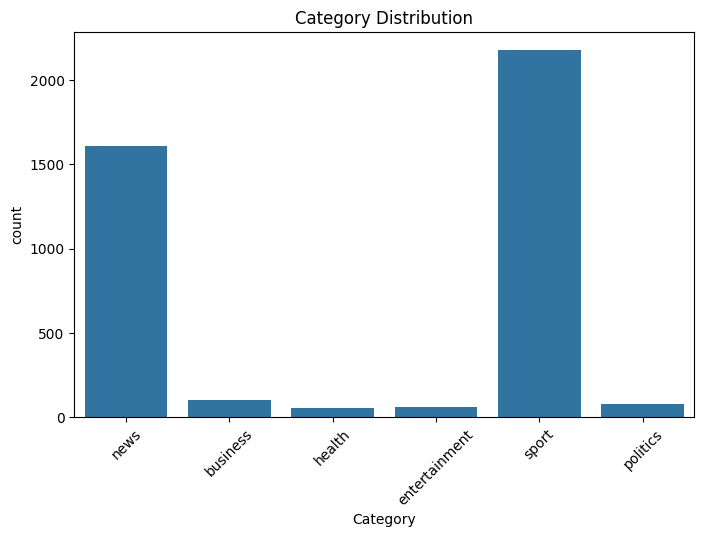

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Category countplot (vertical bars)
plt.figure(figsize=(8,5))
sns.countplot(x="Category", data=df)   # x-axis → categories, y-axis → count
plt.title("Category Distribution")
plt.xticks(rotation=45)  # rotate labels if they overlap
plt.show()


In [9]:
# Handling missing values
df['Category'] = df['Category'].fillna("Unknown")
df['Section'] = df['Section'].fillna("Unknown")
df['Headline'] = df['Headline'].fillna("")
df['Description'] = df['Description'].fillna("")
df['Article text'] = df['Article text'].fillna("")
df['Keywords'] = df['Keywords'].fillna("")


In [12]:
df = df.drop_duplicates(subset=['Headline', 'Article text'])


In [11]:
df['Date published'] = pd.to_datetime(df['Date published'], errors='coerce')
df['year'] = df['Date published'].dt.year
df['month'] = df['Date published'].dt.month
df['day'] = df['Date published'].dt.day
df['weekday'] = df['Date published'].dt.day_name()


In [13]:
df['headline_len'] = df['Headline'].apply(len)
df['desc_len'] = df['Description'].apply(len)
df['article_len'] = df['Article text'].apply(len)

df['headline_wordcount'] = df['Headline'].apply(lambda x: len(str(x).split()))
df['article_wordcount'] = df['Article text'].apply(lambda x: len(str(x).split()))


In [14]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)  # keep only letters
    text = " ".join([word for word in text.split() if word not in stop])
    return text

df['clean_headline'] = df['Headline'].apply(clean_text)
df['clean_description'] = df['Description'].apply(clean_text)
df['clean_article'] = df['Article text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Category_encoded'] = le.fit_transform(df['Category'])
df['Section_encoded'] = le.fit_transform(df['Section'])


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['headline_len', 'desc_len', 'article_len']] = scaler.fit_transform(
    df[['headline_len', 'desc_len', 'article_len']]
)


In [17]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download resources (only first time)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Example text data (replace with your df['ColumnName'])
text = "This is an example: cleaning, preprocessing, and stemming texts!"

# 1. Convert text to lowercase
text = text.lower()

# 2. Remove punctuation/special characters
text = re.sub(r'[^a-z\s]', '', text)

# 3. Remove extra whitespaces
text = re.sub(r'\s+', ' ', text).strip()

# 4. Split text into separate words (tokenization)
words = nltk.word_tokenize(text)

# 5. Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [w for w in words if w not in stop_words]

# 6. Apply Porter Stemmer on every word
stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(w) for w in filtered_words]

print("Original Text:", text)
print("Tokenized Words:", words)
print("After Stopword Removal:", filtered_words)
print("After Stemming:", stemmed_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Original Text: this is an example cleaning preprocessing and stemming texts
Tokenized Words: ['this', 'is', 'an', 'example', 'cleaning', 'preprocessing', 'and', 'stemming', 'texts']
After Stopword Removal: ['example', 'cleaning', 'preprocessing', 'stemming', 'texts']
After Stemming: ['exampl', 'clean', 'preprocess', 'stem', 'text']


In [18]:
df['Category'].value_counts()

,count
Category,
sport,2176
news,1611
business,104
politics,75
entertainment,58
health,52


In [19]:
df['Section'].value_counts()

,count
Section,
sport,1088
europe,800
football,618
uk,376
tennis,197
golf,173
us,134
australia,114
motorsport,100


In [21]:
# Uninstall existing tensorflow installation
!pip uninstall -y tensorflow

# Install tensorflow with necessary dependencies
!pip install tensorflow

Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.


In [3]:
import pandas as pd
from sklearn.metrics import f1_score # Import f1_score here as well

# 1. Load Dataset
# --------------------------
# Replace this with your actual dataset
data = pd.read_csv("/content/Articles.csv")  # ['final_cleaned_text', 'Sentiments']
df = data # Use df variable consistently
X = df['Article text'].astype(str) # Use the correct column name
X.fillna('', inplace=True) # Fill with empty string instead of 'too'
y = df['Category'].astype('category').cat.codes  # Use Category for sentiment as indicated by previous analysis

# --------------------------
# Helper: Macro F1 calculation
# --------------------------
def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

results = []

In [9]:
# import numpy as np
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import GradientBoostingClassifier
# from gensim.models import Word2Vec, KeyedVectors
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import f1_score # Import f1_score here as well

# # --------------------------
# # 2. BOW + GBoost
# # --------------------------
# vectorizer = CountVectorizer()
# X_bow = vectorizer.fit_transform(X)
# X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=100)

# gb_model = GradientBoostingClassifier()
# gb_model.fit(X_train, y_train)
# y_pred = gb_model.predict(X_test)
# f1_bow = macro_f1(y_test, y_pred)
# results.append(["BOW", "GBoost", f1_bow])

# # --------------------------
# # 3. Word2Vec (Skip-gram) + LSTM
# # --------------------------
# sentences = [text.split() for text in X]
# w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1)

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X)
# sequences = tokenizer.texts_to_sequences(X)
# word_index = tokenizer.word_index
# X_seq = pad_sequences(sequences, maxlen=100)

# embedding_matrix = np.zeros((len(word_index) + 1, 100))
# for word, i in word_index.items():
#     if word in w2v_model.wv:
#         embedding_matrix[i] = w2v_model.wv[word]

# X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=42)

# model_w2v = Sequential()
# model_w2v.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False))
# model_w2v.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# model_w2v.add(Dense(3, activation='softmax'))
# model_w2v.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=[])
# model_w2v.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

# y_pred = np.argmax(model_w2v.predict(X_test), axis=1)
# f1_w2v = macro_f1(y_test, y_pred)
# results.append(["Word2Vec (Skip-gram)", "LSTM", f1_w2v])

# # --------------------------
# # 4. GloVe (100d) + LSTM
# # --------------------------
# glove_path = '/content/drive/MyDrive/0- July-Dec 2025/5th sem Intro to LLM and GenAI/Classroom Mini Projects/Part-2/glove.6B.100d.txt.word2vec'
# glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False)

# embedding_matrix = np.zeros((len(word_index) + 1, 100))
# for word, i in word_index.items():
#     if word in glove_model:
#         embedding_matrix[i] = glove_model[word]

# model_glove = Sequential()
# model_glove.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False))
# model_glove.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# model_glove.add(Dense(3, activation='softmax'))
# model_glove.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=[])
# model_glove.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

# y_pred = np.argmax(model_glove.predict(X_test), axis=1)
# f1_glove = macro_f1(y_test, y_pred)
# results.append(["GloVe (100d)", "LSTM", f1_glove])

# # --------------------------
# # 5. Comparison Table
# # --------------------------
# df_results = pd.DataFrame(results, columns=["Representation Technique", "Model Type", "Macro F1 Score"])
# print(df_results)

In [10]:
# ==============================
# Step 1: Import Libraries
# ==============================
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# ==============================
# Step 2: Load Dataset
# ==============================
df = pd.read_csv("Articles.csv")

# assuming dataset has 'text' and 'label' columns
texts = df['Article text'].astype(str).values
labels = df['Category'].values

# ==============================
# Step 3: Preprocess Text
# ==============================
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # remove punctuation
    return text

texts = [clean_text(t) for t in texts]

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(np.unique(labels))
labels = to_categorical(labels, num_classes=num_classes)

# ==============================
# Step 4: Tokenize & Pad Sequences
# ==============================
max_words = 20000   # vocab size
max_len = 200       # max length per article
embedding_dim = 100 # embedding size

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

X = pad_sequences(sequences, maxlen=max_len)
y = labels

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ==============================
# Step 5: Build Model
# ==============================
model = Sequential()

# Embedding layer (fine-tunable)
model.add(Embedding(input_dim=min(max_words, len(word_index)+1),
                    output_dim=embedding_dim,
                    input_length=max_len,
                    trainable=True))  # fine-tune embeddings

# Bidirectional LSTM
model.add(Bidirectional(LSTM(128, return_sequences=False)))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# ==============================
# Step 6: Compile & Train
# ==============================
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32,
                    verbose=1)

# ==============================
# Step 7: Evaluate
# ==============================
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 91s 836ms/step - accuracy: 0.4811 - loss: 1.2459 - val_accuracy: 0.5208 - val_loss: 1.0393
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 143s 845ms/step - accuracy: 0.6833 - loss: 0.7749 - val_accuracy: 0.8493 - val_loss: 0.6098
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 806ms/step - accuracy: 0.8872 - loss: 0.3593 - val_accuracy: 0.7243 - val_loss: 0.7674
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 146s 847ms/step - accuracy: 0.8732 - loss: 0.3076 - val_accuracy: 0.8603 - val_loss: 0.6905
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 139s 814ms/step - accuracy: 0.9329 - loss: 0.1720 - val_accuracy: 0.8713 - val_loss: 0.6567
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 87s 851ms/step - accuracy: 0.9674 - loss: 0.0847 - val_accuracy: 0.8689 - val_loss: 0.7661
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 149s 921ms/step - accuracy: 0.9701 - loss: 0.0743 - val_accuracy: 0.8762 - val_loss: 0.7452
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 83s 816ms/step - accuracy: 0.9723 - los